# Domain Decomposition of CRY2–FBXL3–SKP1 with a Gaussian Network Model (GNM)

## Introduction

Visual identification of mobile domains in proteins and protein complexes is seldom reproducible as 2D visualization is insufficient for gauging the flexibility and connectivity of 3D structures. Conversely, methods for describing the physical nature of proteins in an automatic and analytical way take the judgment away from the researcher and allow conclusions to be drawn free from bias, while providing quantitative data about the mobility of large and complex systems. Kundu et al. have described a method of using an elastic network model (ENM) or Gaussian network model (GNM) [1] to automatically decompose mobile domains of monomeric proteins [2]. We have extended this to the study of multisubunit protein complexes — in this case CRY2–FBXL3–SKP1 — by performing the analysis on each subunit as a monomer and visually confirming that the mobility of the identified domains are not hindered by their neighbors.

The approach will be described over the next several sections, first applying the algorithm to a simple system that is easily deconvoluted visually and then extending the algorithm to CRY2–FBXL3–SKP1. The software is initialized by importing the following libraries.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy.spatial.distance as dist

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## GNM Example — A Simple 6-node Graph

To borrow the rather elegant example provided by Kundu et al. [2] for explaining the algorithm, let us first consider a simple system that can be represented as a graph of 6 nodes. Edges are drawn in to signify adjacency, although the algorithm itself will define adjacency based on Euclidean distance. In this example, the graph is drawn such that connected nodes will be spaced 7.0 arbitrary units apart.

In [2]:
# Set the distance between nodes
d = 7.0

# For points connected diagonally (an equilateral triangle), how much should 
# the x-value change
x = np.sin(np.pi/3) * d

graph = np.array([[    0.0, 0.0],
                  [      0,   d],
                  [      x, d/2],
                  [  x + d, d/2],
                  [2*x + d, 0.0],
                  [2*x + d,   d]])

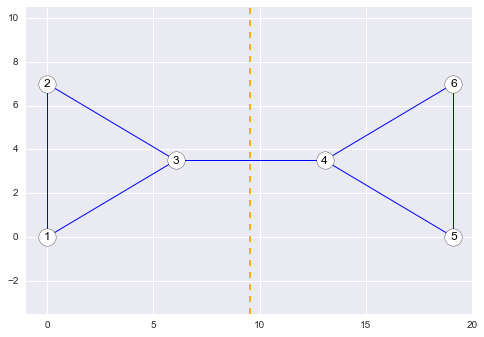

In [3]:
G = nx.Graph()
edges = [(1,2), (2,3), (1,3), (3,4), (4,5), (4,6), (5,6)]
G.add_edges_from(edges)

pos = {i+1:g for i,g in enumerate(graph)}
plt.xlim(-1,20)
plt.ylim(-3.5,10.5)
nx.draw_networkx(G, pos=pos, node_color='white', edge_color='blue')
plt.vlines((x + d/2), -3.5, 10.5, color='orange', linestyles='--')

The Laplacian matrix ($L$), or Kirchhoff matrix [3], describes both the valency and the connectivity of each node as given by the logic shown in the following equations. It is a square, symmetric matrix with the dimensions equal to the total number of nodes. Each unit of the matrix $l_{ij}$ represents the relationship between the two corresponding nodes $i$ and $j$, with a $-1$ representing adjacency except for the diagonal of the matrix, where $i=j$. Cells along the diagonal describe the valency of each node — how many nodes are adjacent. In the case of a protein, adjacency of residues is approximated by representing the $\alpha$-carbons as nodes and determining adjacency from the distance between $\alpha$-carbons. Given two $\alpha$-carbons $i$ and $j$, if the distance $R_{ij}$ between them is less than or equal to some critical radius $r_c$, then they are adjacent.


$$
l_{i,j} = 
\begin{cases}
  -1                                 & \text{if } i \neq j \text{ and } R_{ij} \leq r_c \\
   0                                 & \text{if } i \neq j \text{ and } R_{ij} > r_c \\
  -\sum\limits_{i,j \neq j}{l_{i,j}} & \text{if } i = j
\end{cases}
\qquad
L = \begin{bmatrix}
    2 & -1 & -1 &  0 &  0 &  0 \\
   -1 &  2 & -1 &  0 &  0 &  0 \\
   -1 & -1 &  3 & -1 &  0 &  0 \\
    0 &  0 & -1 &  3 & -1 & -1 \\
    0 &  0 &  0 & -1 &  2 & -1 \\
    0 &  0 &  0 & -1 & -1 &  2 \\
\end{bmatrix}
$$

Specifically, the Laplacian matrix is given by subtracting the adjacency matrix ($A$) from the degree matrix ($D$), shown below. The adjacency matrix describes the edges in the graph, such that if if vertex $i$ and vertex $j$ are adjacent, then both $a_{ij}$ and $a_{ji}$ will be equal to $1$, and otherwise equal to $0$. The degree matrix shows the valency of each node along the diagonal, such that if $i=j$ then $d_{ij}$ will be the number of edges connecting to that node. The diagonal of the matrix is equivalent to the vector that would result from summing either the rows or columns of the adjacency matrix.

$$
   L = D - A = \begin{bmatrix}
    2 &  0 &  0 &  0 &  0 &  0 \\
    0 &  2 &  0 &  0 &  0 &  0 \\
    0 &  0 &  3 &  0 &  0 &  0 \\
    0 &  0 &  0 &  3 &  0 &  0 \\
    0 &  0 &  0 &  0 &  2 &  0 \\
    0 &  0 &  0 &  0 &  0 &  2 \\
  \end{bmatrix} - \begin{bmatrix}
   0 & 1 & 1 & 0 & 0 & 0 \\
   1 & 0 & 1 & 0 & 0 & 0 \\
   1 & 1 & 0 & 1 & 0 & 0 \\
   0 & 0 & 1 & 0 & 1 & 1 \\
   0 & 0 & 0 & 1 & 0 & 1 \\
   0 & 0 & 0 & 1 & 1 & 0 \\
  \end{bmatrix}
$$

The algorithm can be implemented in Python as follows. The graph has been defined such that connected nodes have a distance (variable `d`) of 7.0, and consequently connection can be defined by inter-node distance merely by using an $r_c$ of 7.0. First, a distance matrix of the graph is generated from the array `graph` of coordinates.


In [4]:
distances = dist.cdist(graph,graph).round()
distances

array([[  0.,   7.,   7.,  14.,  19.,  20.],
       [  7.,   0.,   7.,  14.,  20.,  19.],
       [  7.,   7.,   0.,   7.,  14.,  14.],
       [ 14.,  14.,   7.,   0.,   7.,   7.],
       [ 19.,  20.,  14.,   7.,   0.,   7.],
       [ 20.,  19.,  14.,   7.,   7.,   0.]])

The adjacent matrix should represent the connected nodes ($R_{ij} \leq r_c$) with a 1. Because nodes by definition have a distance of $0.0$ against themselves, we must exclude values of $0.0$ to prevent the diagonal from having a value of $1$, thus the logic of defining adjacency is when distance is $0 \lt R_{ij} \leq r_c$.

In [5]:
adjacency = ((distances > 0) & (distances <= 7.0)).astype('int')
adjacency

array([[0, 1, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [1, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 1, 0]])

The programmatically generated adjacency matrix is equivalent to the previously described matrix that was assigned visually. As the degree matrix ($D$) is defined as the number of edges connecting the node, the adjacency matrix can be summed along either the horizontal or vertical axis to get a vector of the valency. To format this along the diagonal, this vector can be multiplied element-wise by the identity matrix, yielding the degree matrix.

In [6]:
valency = (adjacency.sum(axis=0) * np.identity(graph.shape[0])).astype('int')
valency

array([[2, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0],
       [0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 2]])

Finally, subtraction is performed to generate the Laplacian matrix ($L$).


In [7]:
valency - adjacency

array([[ 2, -1, -1,  0,  0,  0],
       [-1,  2, -1,  0,  0,  0],
       [-1, -1,  3, -1,  0,  0],
       [ 0,  0, -1,  3, -1, -1],
       [ 0,  0,  0, -1,  2, -1],
       [ 0,  0,  0, -1, -1,  2]])

The result is the same matrix that was constructed visually. These steps can be assembled into a function for reuse when the protein monomers are analyzed.

In [8]:
def Laplacian(coords, rc):
    distances = dist.cdist(coords,coords)
    adjacency = ((distances > 0) & (distances <= rc))
    valency = adjacency.sum(axis=0) * np.identity(coords.shape[0])
    return (valency - adjacency).astype('int')

Laplacian(graph, 8.0)

array([[ 2, -1, -1,  0,  0,  0],
       [-1,  2, -1,  0,  0,  0],
       [-1, -1,  3, -1,  0,  0],
       [ 0,  0, -1,  3, -1, -1],
       [ 0,  0,  0, -1,  2, -1],
       [ 0,  0,  0, -1, -1,  2]])

In [9]:
L = Laplacian(graph, 8.0)

The next step is to perform singular value decomposition (SVD) on the Laplacian matrix. The function as implemented in NumPy (`numpy.linalg.svd`) returns a vector of eigenvalues `s` and the corresponding array of eigenvectors `V`. The second smallest eigenvalue is called the _algebraic connectivity_ and this value represents the connectedness of the graph, with nonzero values indicating that a graph is in fact connected [4]. Areas of the graph where connectedness is diminished indicate increased flexibility. More intuitively, one can imagine that if $\alpha$-carbons are in close proximity, they would experience more interaction, and it is less likely that the protein would be flexible at that point. The eigenvector corresponding to the algebraic connectivity is called the Fielder vector. Points where the Fiedler vector intersects the $x$-axis indicate lower connectivity and thus greater flexibility in the graph. In the case of a graph representing a protein, this is an interface between two mobile domains. To extract the Fielder vector programmatically, a copy is made of the array `s` and is then sorted. The second value in the sorted array `s_sort[1]` is the eigenvalue that corresponds to the Fiedler vector. Thus, the position of this value in the original eigenvalue array `s` gives the position of the Fiedler vector in the array `V`.

In [10]:
U, s, V = np.linalg.svd(L, full_matrices=True)

s_sort = s.copy()
s_sort.sort()
Fiedler = V[s == s_sort[1]][0]

Fiedler

array([-0.46470513, -0.46470513, -0.26095647,  0.26095647,  0.46470513,
        0.46470513])

The SVD step should also be packaged as a function for reuse throughout the remainder of this analysis.

In [11]:
def get_Fiedler(L):
    U, s, V = np.linalg.svd(L, full_matrices=True)
    s_sort = s.copy()
    s_sort.sort()
    return V[s == s_sort[1]][0]

get_Fiedler(L)

array([-0.46470513, -0.46470513, -0.26095647,  0.26095647,  0.46470513,
        0.46470513])

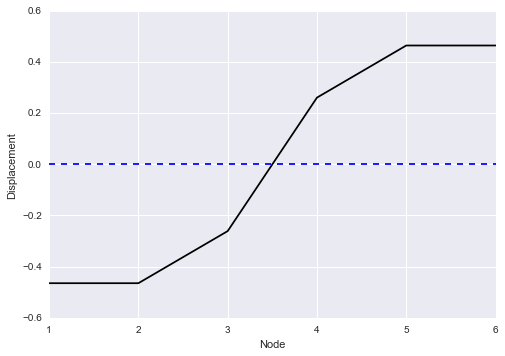

In [12]:
plt.plot(np.arange(1,7), Fiedler, '-', color = 'black')
plt.hlines(0,1,6, color='blue', linestyle='--')
plt.xlabel('Node')
plt.ylabel('Displacement')

As we'd expect from visually inspecting the graph, the Fiedler vector crosses the $x$-axis between nodes 3 and 4, indicating that this is the most flexible point in the graph. Using this simple example borrowed from Kundu et al. [2], the utility of this algorithm is demonstrated. Further, it is clear that the algorithm has been successfully implemented in Python and can be reused for the remainder of this research.

## Application of the GNM to CRY2–FBXL3–SKP1

This algorithm was originally proposed for use on monomeric proteins, and the authors provided no examples of it being validated for multiprotein complexes. It was therefore our intention to test the algorithm on CRY2–FBXL3–SKP1 and evaluate the results of domain decomposition. Treating the entire complex as a single chain is problematic, however. Each subunit is a separate chain, and as such the distance between the C-terminus of one subunit and the N-terminus of the next is much farther than the typical space between residues in sequence. It should therefore be preferable to represent each chain as a separate graph, otherwise one would expect to see false negatives in between subunit chains where connectivity would appear to be very low. This would manifest as the Fiedler vector abruptly changing sign. To demonstrate this issue, the algorithm will first be demonstrated on the entire complex as a single chain and then on each subunit individually.

The following function loads the PDB file as a data.

In [13]:
def pdb_to_df(fname):
    with open(fname, 'r') as PDBfile:
        PDBlines = PDBfile.read().splitlines()
        PDBlines = filter(lambda x: x[0:4] == 'ATOM', PDBlines)
        
    ATOMdata = [[x[0:6],
                 x[6:11],
                 x[12:16],
                 x[16:17],
                 x[17:20],
                 x[21:22],
                 x[22:26],
                 x[26:27],
                 x[30:38],
                 x[38:46],
                 x[46:54],
                 x[54:60],
                 x[60:66],           
                 x[76:78],
                 x[78:80]] for x in PDBlines]
    
    headers = ['Record', 'serial', 'name', 'altLoc', 'Resn',
            'chainID', 'resSeq', 'iCode', 'x', 'y', 'z', 'occupancy', 
            'tempFactor', 'element', 'charge']
    
    ATOMdata = [[s.strip() for s in inner] for inner in ATOMdata]
    df = pd.DataFrame(ATOMdata, columns=headers)
    df = df.set_index(df['serial'].values)

    return df

In [14]:
atoms = pdb_to_df('4i6j.pdb')
atoms.head()

,Record,serial,name,altLoc,Resn,chainID,resSeq,iCode,x,y,z,occupancy,tempFactor,element,charge
1,ATOM,1,N,,ALA,A,21,,-24.735,7.280,-10.679,1.00,71.10,N,
2,ATOM,2,CA,,ALA,A,21,,-25.872,6.526,-10.161,1.00,72.66,C,
3,ATOM,3,C,,ALA,A,21,,-25.496,5.716,-8.916,1.00,68.57,C,
4,ATOM,4,O,,ALA,A,21,,-24.760,4.735,-9.000,1.00,72.94,O,
5,ATOM,5,CB,,ALA,A,21,,-26.447,5.616,-11.248,1.00,61.64,C,


Next, the Cartesian coordinates of the $\alpha$-carbons are subset from the data frame as a single chain and processed using the domain decomposition algorithm.

In [15]:
entire_complex = atoms[(atoms['name'] == 'CA')][['x', 'y', 'z']]
L = Laplacian(entire_complex, rc=10.0)
Fiedler = get_Fiedler(L)

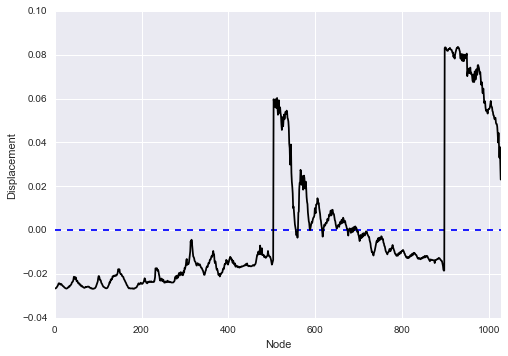

In [16]:
m, n = entire_complex.shape

plt.plot(np.arange(m)+1, Fiedler, color = 'black')
plt.hlines(0,1,m+1, color='blue', linestyle='--')
plt.xlim(0, m+1)
plt.xlabel('Node')
plt.ylabel('Displacement')

Sharp vertical jumps are visible between nodes 503 and 504 (the CRY2 C-terminus
and the FBXL3 N-terminus), as well as between nodes 897 and 898 (FBXL3
C-terminus and the SKP1 N-terminus). The mobile domains cannot be
reliably predicted in this manner. The next step is therefore to treat each subunit as a separate graph and perform the analysis on each one individually.

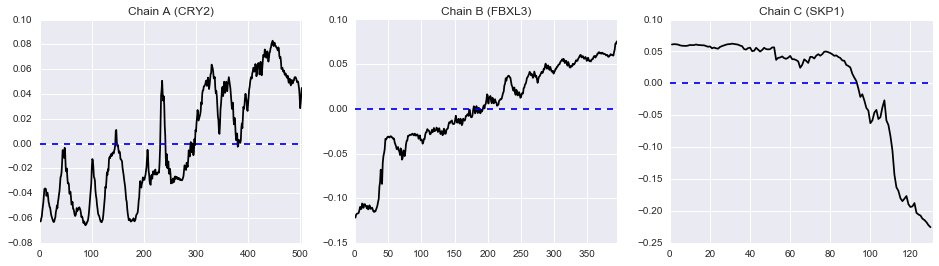

In [17]:
fig = plt.figure(figsize=(16,4))
chains = {'A': 'CRY2', 'B': 'FBXL3', 'C': 'SKP1'}
for i, chain in enumerate(['A', 'B', 'C']):
    subunit = atoms[(atoms['name'] == 'CA') & 
                    (atoms['chainID'] == chain)][['x', 'y', 'z']].values

    L = Laplacian(subunit, rc=10.0)
    Fiedler = get_Fiedler(L)
    m, n = subunit.shape

    ax = fig.add_subplot(1,3,i+1)
    ax.plot
    ax.plot(np.arange(m)+1, Fiedler, color = 'black')
    ax.axhline(0, color='blue', linestyle='--')
    ax.set_xlim(0, m+1)
    ax.set_title('Chain %s (%s)' % (chain, chains[chain]))

plt.show()

For each subunit, the Fiedler vector intersects the $x$-axis one or more times. The CRY2 Fiedler vector intersects the $x$-axis multiple times, however Kundu et al. suggest that segments of the Fielder vector that cross the $x$-axis but are ten residues or shorter should not be considered mobile domains due to their length not being sufficient to confer significant flexibility. The CRY2(256–265) segment that is positive is right on the cusp of this cutoff, however upon further investigation it becomes clear that this apparent flexibility is due to the absence of CRY2(252–255) in the crystal structure ([PDB:4I6J](http://www.rcsb.org/pdb/explore.do?structureId=4i6j)). The only other residues missing from CRY2 in the crystal structure are CRY2(1–20) and CRY2(528–544), which are the N- and C-terminal residues and therefore do not cause a break in the sequence of nodes that are subjected to analysis. For FBXL3, there is also substantial fluctuation at the $x$-axis between nodes 179–191, which correspond to FBXL3(213–225). Visualization of the structure reveals that the residues are part of an $\alpha$-helix, with FBXL3(226) being the beginning of a weak point in the bent $\beta$-sheet. The SKP1 Fiedler vector crosses the $x$-axis only once with a very clean drop between nodes 93–94, which correspond to SKP1(125–126). The missing residues for this subunit include SKP1(1–2, 34–43, 65–84, 163) — quite a substantial number of residues breaking the sequence, however upon visual inspection of the structure, these are not close in space to the domain interface, and therefore cannot account for the change in sign of the Fiedler vector.


In [18]:
interfaces = {'A': 297, 'B': 191, 'C': 92}

Although visual inspection confirmed that none of the missing residues created a false interface between domains, it is still possible that missing domains may shift the Fiedler vector by a small amount, so manual adjustment of a small number of residues was performed to ensure that rigid structures such as $\alpha$-helices would not be broken. Therefore, three domain interfaces have been identified for CRY2–FBXL3–SKP1 — CRY2(320:321), FBXL3(223:224), and SKP1(129:130).

## Examining Intersubunit Interactions

Mobile domains were identified in each subunit, however interactions with neighboring subunits must also be considered when determining the actual flexibility at these interfaces. By extending the previously implemented approximation of distance between $\alpha$-carbons as determining connectivity, we can automatically determine if the flexibility of any giving domain is inhibited by intersubunit interactions.

In the following analysis, domain interfaces are shown by dashed lines. Interactions are based on either an $r_c$ of 7.0 (red) or 10.0 (yellow). Both values of $r_c$ are evaluated to gauge the degree of interaction and the number of interaction between each domain, however whether this interaction restricts independent movement is somewhat subjective.


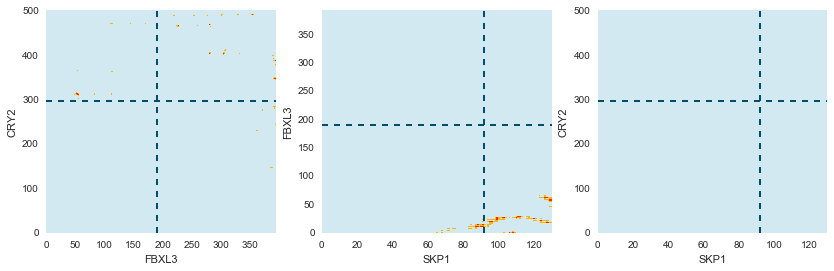

In [19]:
fig = plt.figure(figsize=(14,4))

for i, chain in enumerate([('A','B'), ('B','C'), ('A','C')]):
    M, N = [atoms[(atoms['name'] == 'CA') & 
             (atoms['chainID'] == ch)][['x', 'y', 'z']].values for ch in chain]
    interaction7 = dist.cdist(M,N) <= 7.0
    interaction10 = dist.cdist(M,N) <= 10.0
    interaction = interaction7*1 + interaction10*1

    m,n = [x.shape[0] for x in [M,N]]
    ax = fig.add_subplot(1,3,i+1)
    ax.pcolormesh(interaction, cmap=mpl.colors.ListedColormap(['#D3E9F1', '#FFB400', '#FF2800']))
    ax.axvline(interfaces[chain[1]], color='#024E68', ls='--', lw=2.0)
    ax.axhline(interfaces[chain[0]], color='#024E68', ls='--', lw=2.0)
    ax.set_xlabel(chains[chain[1]])
    ax.set_ylabel(chains[chain[0]])

    ax.set_xlim(0,n)
    ax.set_ylim(0,m)

The N-terminal domain CRY2 shows very little interaction with FBXL3 and absolutely no interaction with SKP1, suggesting that it can in fact move independently of the rest of the complex. The C-terminal domains of FBXL3 and CRY2 show a great deal of interaction, but this is known from inspecting the crystal structure and is obvious visually. Therefore structures generated through bending at the CRY2 pivot point should involve the N-terminal domain moving relative to the rest of the complex.

As mentioned previously, there is a great deal of interaction between the C-terminal domain of FBXL3 and the C-terminal domain of CRY2, however this is known from a more thorough analysis of the crystal structure — the C-terminal tail of FBXL3 is docked in the CRY2 binding pocket and there is substantial interaction between CRY2 and the leucine-rich-repeat (LRR) of FBXL3 [5]. The portion of the LRR that belongs to the N-terminal domain of FBXL3 also interacts with CRY2, however it is clear from the interaction plot that the N-terminal domain is quite free to move relative to the C-terminal domain. As the N-terminal domain of FBXL3 is known to interact with SKP1 both from the crystal structure and from the above interaction studies, it suggests that the pivot point of FBXL3 involves the motion of the N-terminus of FBXL3 moving with SKP1 independently of CRY2.

Finally, there is the motion of SKP1 to consider. SKP1 has no interaction with CRY2 whatsoever. The C-terminal domain of SKP1 shows a great deal of interaction with FBXL3, but once again it is clear that the N-terminal domain — though it does have interactions with FBXL3 — is indeed more free to move in comparison.

## Conclusions

A previously described GNM for identifying mobile domains in monomeric proteins has been successfully implemented in Python. The previously described methodology has been extended to identify mobile domains in multisubunit protein complexes, and was used to identify three potential pivot points in CRY2–FBXL3–SKP1 — one in each subunit. Domain decomposition in each subunit is automatic, followed by visual inspection of the intersubunit distances between $\alpha$-carbons to verify that interactions with neighboring subunits are not restricting the flexibility of the domain.

## References

  1. Sibsankar Kundu, Julia S. Melton, Dan C. Sorensen, and George N. Phillips Jr. Dynamics of proteins in crystals: Comparison of experiment with simple models. _Biophysical Journal_, 83(2):723–732, **2002**.

  2. Sibsankar Kundu, Dan C. Sorensen, and George N. Phillips. Automatic domain decomposition of proteins by a Gaussian network model. _Proteins: Structure, Function, and Bioinformatics_, 57(4):725–733, 2004

  3. D. Babić, D.J. Klein, I. Lukovits, S. Nikolić, and N. Trinajstić. Resistance-distance matrix: A computational algorithm and its application. _International Journal of Quantum Chemistry_, 90(1):166–176, **2002**.
  
  4. Bojan Mohar. The Laplacian spectrum of graphs. In Yousef Alavi, G. Chartrand, O.R. Oellermann, and A.J. Schwenk (Editors), _Graph Theory, Combinatorics, and Applications_, volume 2, pages 871–898. Wiley, **1991**.
  
  5. Weiman Xing, Luca Busino, Thomas R. Hinds, Samuel T. Marionni, Nabiha H. Saifee, Matthew F. Bush, Michele Pagano, and Ning Zheng. SCF<sup>FBXL3</sup> ubiquitin ligase targets cryptochromes at their cofactor pocket. _Nature_, 496(7443):64–68, **2013**.